<a href="https://colab.research.google.com/github/pavan1806/CHANGE_DETECTION_OVER_MULTISPECTRAL_IMAGES_USING_MACHINE_LEARNING_TECHNIQUES/blob/main/CHANGE_DETECTION_OVER_MULTISPECTRAL_IMAGES_USING_MACHINE_LEARNING_TECHNIQUES_A_CASE_STUDY_ON_RUSHIKONDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [47]:
import numpy as np
import cv2
from sklearn.cluster import KMeans
from collections import Counter
import skimage
import scipy.stats as stats
import pandas as pd
from sklearn.decomposition import PCA

In [48]:
def find_vector_set(diff_image, new_size):
    i = 0
    j = 0
    vector_set = np.zeros((int(new_size[0] * new_size[1] / 25), 25))
    while i < vector_set.shape[0]:
        while j < new_size[0]:
            k = 0
            while k < new_size[1]:
                block   = diff_image[j:j+5, k:k+5]
                feature = block.ravel()
                vector_set[i, :] = feature
                k = k + 5
            j = j + 5
        i = i + 1

    mean_vec   = np.mean(vector_set, axis = 0)
    vector_set = vector_set - mean_vec
    print(np.size(vector_set,0),np.size(vector_set,1))
    return vector_set, mean_vec

In [49]:
def find_FVS(EVS, diff_image, mean_vec, new):

    i = 2
    feature_vector_set = []

    while i < new[0] - 2:
        j = 2
        while j < new[1] - 2:
            block = diff_image[i-2:i+3, j-2:j+3]
            feature = block.flatten()
            feature_vector_set.append(feature)
            j = j+1
        i = i+1

    FVS = np.dot(feature_vector_set, EVS)
    FVS = FVS - mean_vec
    print("\nfeature vector space size", FVS.shape)
    return FVS


In [50]:
def clustering(FVS, components, new):

    kmeans = KMeans(components)
    kmeans.fit(FVS)
    output = kmeans.predict(FVS)
    count  = Counter(output)

    least_index = min(count, key = count.get)
    change_map  = np.reshape(output,(new[0] - 4, new[1] - 4))
    return least_index, change_map

In [51]:
if __name__ == "__main__":
    a = "/content/gdrive/MyDrive/MiNI/Inputs/input2015.png"
    b = "/content/gdrive/MyDrive/MiNI/Inputs/input2021.png"

In [52]:
img1 = cv2.imread(a)
img2 = cv2.imread(b)

In [53]:
img1=np.array(img1)
img2=np.array(img2)

In [54]:
np.shape(img1)

(815, 1307, 3)

In [55]:
np.shape(img2)

(815, 1307, 3)

In [56]:
image1=img1[:,:,1]
image2=img2[:,:,1]

In [57]:
new_size = np.asarray(img1.shape) / 5
new_size = new_size.astype(int) * 5

In [58]:
image1 = cv2.resize(image1, (new_size[1],new_size[0])).astype(np.int16)
image2 = cv2.resize(image2, (new_size[1],new_size[0])).astype(np.int16)

In [59]:
diff_image = abs(image1 - image2)
diff_image

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

In [60]:
vector_set, mean_vec = find_vector_set(diff_image, new_size)
pca  = PCA()
pca.fit(vector_set)
EVS = pca.components_

42543 25


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


In [61]:
FVS  = find_FVS(EVS, diff_image, mean_vec, new_size)
k = 3
least_index, change_map = clustering(FVS, k, new_size)

change_map[change_map == least_index] = 255
change_map[change_map != 255] = 0

change_map = change_map.astype(np.uint8)


kernel1    = np.asarray(((0,0,1,0,0),
                         (0,1,1,1,0),
                         (1,1,1,1,1),
                         (0,1,1,1,0),
                         (0,0,1,0,0)), dtype=np.uint8)


feature vector space size (1055111, 25)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [62]:
kernel2=np.asarray(((0,0,0,1,0,0,0),
                   (0,0,1,1,1,0,0),
                   (0,1,1,1,1,1,0),
                   (1,1,1,1,1,1,1),
                   (0,1,1,1,1,1,0),
                   (0,0,1,1,1,0,0),
                   (0,0,0,1,0,0,0)),dtype=np.uint8)

cleanChangeMap = cv2.erode(change_map,kernel1)
clean=cv2.dilate(cleanChangeMap,kernel1)

In [63]:
np.shape(img1)

(815, 1307, 3)

In [64]:
np.shape(img2)

(815, 1307, 3)

In [65]:
cleanChangeMap_New=cv2.resize(cleanChangeMap,(np.size(img1,1),np.size(img1,0))).astype(np.int16)

In [66]:
np.shape(cleanChangeMap_New)

(815, 1307)

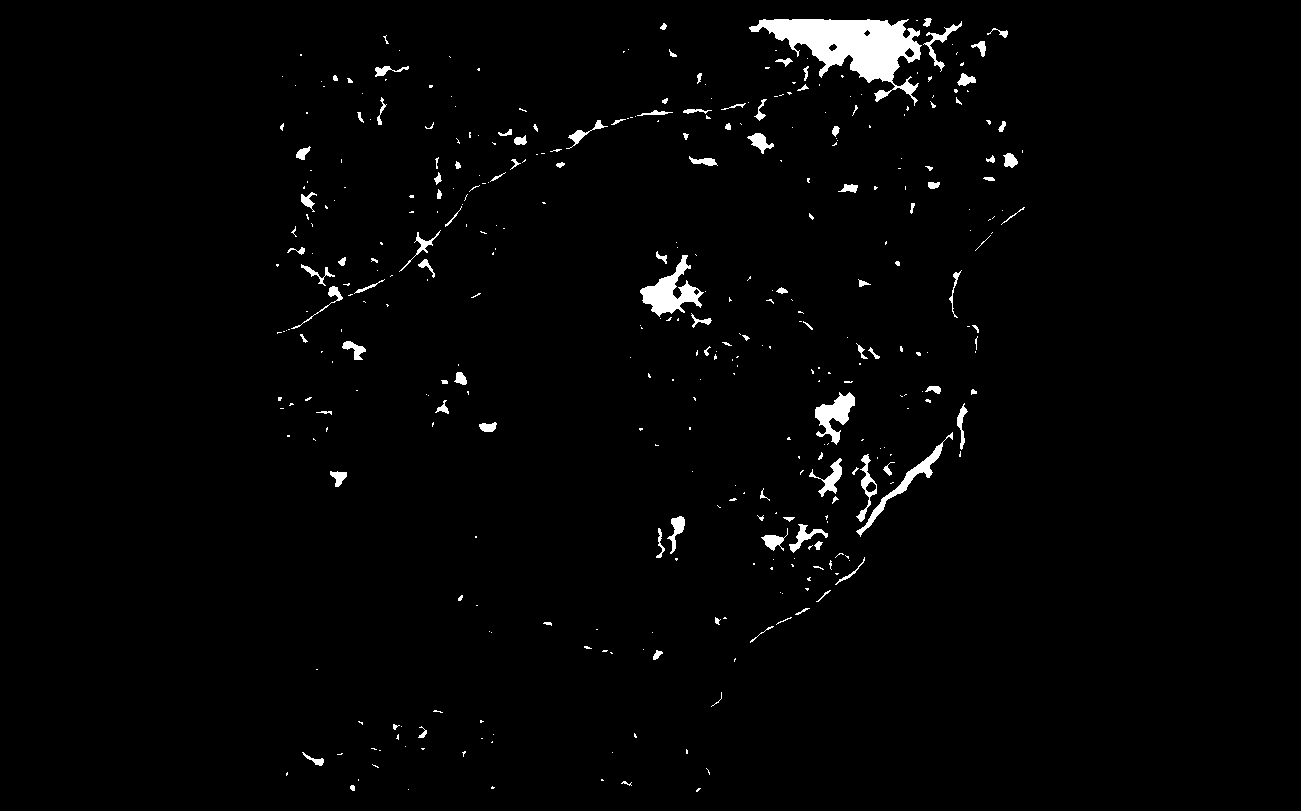

In [67]:
from google.colab.patches import cv2_imshow
cv2_imshow(cleanChangeMap)

### Normalized Difference Vegetation Index

### Import requires libraries
This tutorial uses just Python core libraries, Scipy (Numpy, Matplotlib and others) and GDAL. For Windows users, the most effective way is to download the GDAL Wheel from https://www.lfd.uci.edu/~gohlke/pythonlibs/ and install through pip.

In [68]:
#!pip3 install earthpy

In [69]:
from osgeo import ogr, gdal, osr
import numpy as np
import os
import matplotlib.pyplot as plt

### Setting up the input and output files
We declare the path for the raster bands and the output NDVI and land cover change rasters. The land cover change contour shape path is also defined.

In [70]:
#Input Raster and Vector Paths

#Image-2021
path_B5_2021="/content/gdrive/MyDrive/GoogleEarthPro/2021/clip_LC08_L1TP_141048_20211108_20211117_01_T1_B5.tif"
path_B4_2021="/content/gdrive/MyDrive/GoogleEarthPro/2021/clip_LC08_L1TP_141048_20211108_20211117_01_T1_B4.tif"

#Image-2015
path_B5_2015="/content/gdrive/MyDrive/GoogleEarthPro/2015/clip_LC08_L1TP_141048_20150124_20170413_01_T1_B5.tif"
path_B4_2015="/content/gdrive/MyDrive/GoogleEarthPro/2015/clip_LC08_L1TP_141048_20150124_20170413_01_T1_B4.tif"


In [71]:
#Output Files

#Output NDVI Rasters
path_NDVI_2021 = 'NDVI2021.tif'
path_NDVI_2015 = 'NDVI2015.tif'
path_NDVIChange_21_15 = 'NDVIChange_21_15.tif'

#NDVI Contours
contours_NDVIChange_21_15 = 'NDVIChange_21_15.shp'

In [72]:
#Open raster bands
B5_2021 = gdal.Open(path_B5_2021)
B4_2021 = gdal.Open(path_B4_2021)
B5_2015 = gdal.Open(path_B5_2015)
B4_2015 = gdal.Open(path_B4_2015)

#Read bands as matrix arrays
B52021_Data = B5_2021.GetRasterBand(1).ReadAsArray().astype(np.float32)
B42021_Data = B4_2021.GetRasterBand(1).ReadAsArray().astype(np.float32)
B52015_Data = B5_2015.GetRasterBand(1).ReadAsArray().astype(np.float32)
B42015_Data = B4_2015.GetRasterBand(1).ReadAsArray().astype(np.float32)

### Compare matrix sizes and geotransformation parameters
The operation in between Landsat 8 bands depends that the resolution, size, src, and geotransformation parameters are the same for both images. In case these caracteristics do not coincide a warp, reproyection, scale or any other geospatial process would be necessary.

In [73]:
print(B5_2015.GetProjection()[:80])
print(B5_2021.GetProjection()[:80])
if B5_2015.GetProjection()[:80]==B5_2021.GetProjection()[:80]: print('SRC OK')

PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84
PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84
SRC OK


In [74]:
print(B52015_Data.shape)
print(B52021_Data.shape)
if B52015_Data.shape==B52021_Data.shape: print('Array Size OK')

(693, 672)
(693, 672)
Array Size OK


In [75]:
print(B5_2015.GetGeoTransform())
print(B5_2021.GetGeoTransform())
if B5_2015.GetGeoTransform()==B5_2021.GetGeoTransform(): print('Geotransformation OK')

(737325.0, 30.0, 0.0, 1981875.0, 0.0, -30.0)
(737325.0, 30.0, 0.0, 1981875.0, 0.0, -30.0)
Geotransformation OK


### Get geotransformation parameters
Since we have compared that rasters bands have same array size and are in the same position we can get the some spatial parameters

In [76]:
geotransform = B5_2015.GetGeoTransform()

originX,pixelWidth,empty,finalY,empty2,pixelHeight=geotransform
cols =  B5_2015.RasterXSize
rows =  B5_2021.RasterYSize

In [77]:
projection = B5_2015.GetProjection()

In [78]:
finalX = originX + pixelWidth * cols
originY = finalY + pixelHeight * rows

### Compute the NDVI and store them as a different file
We can compute the NDVI as a matrix algebra with some Numpy functions. The result can be exported as a raster using GDAL and the transformation parameters. In order to have a more effective and clear code we create a function to export rasters.

In [79]:
ndvi2015 = np.divide(B52015_Data - B42015_Data, B52015_Data+ B42015_Data)
ndvi2015[ndvi2015 == 0] = -999

ndvi2021 = np.divide(B52021_Data - B42021_Data, B52021_Data+ B42021_Data)
ndvi2021[ndvi2021 == 0] = -999


print(np.sum(ndvi2015)/len(ndvi2015))
print(np.sum(ndvi2021)/len(ndvi2021))

117.20692415223665
157.0281498015873


In [80]:
def saveRaster(dataset,datasetPath,cols,rows,projection):
    rasterSet = gdal.GetDriverByName('GTiff').Create(datasetPath, cols, rows,1,gdal.GDT_Float32)
    rasterSet.SetProjection(projection)
    rasterSet.SetGeoTransform(geotransform)
    rasterSet.GetRasterBand(1).WriteArray(dataset)
    rasterSet.GetRasterBand(1).SetNoDataValue(-999)
    rasterSet = None

In [81]:
saveRaster(ndvi2015,path_NDVI_2015,cols,rows,projection)

saveRaster(ndvi2021,path_NDVI_2021,cols,rows,projection)

### Plot NDVI Images
We create a function to plot the resulting NDVI images with a colobar

In [82]:
extentArray = [originX,finalX,originY,finalY]
def plotNDVI(ndviImage,extentArray,vmin,cmap):
    ndvi = gdal.Open(ndviImage)
    ds2019 = ndvi.ReadAsArray()
    plt.figure(figsize=(20,15))
    im = plt.imshow(ds2019, vmin=vmin, cmap=cmap, extent=extentArray)#
    plt.colorbar(im, fraction=0.015)
    plt.xlabel('Este')
    plt.ylabel('Norte')
    plt.show()

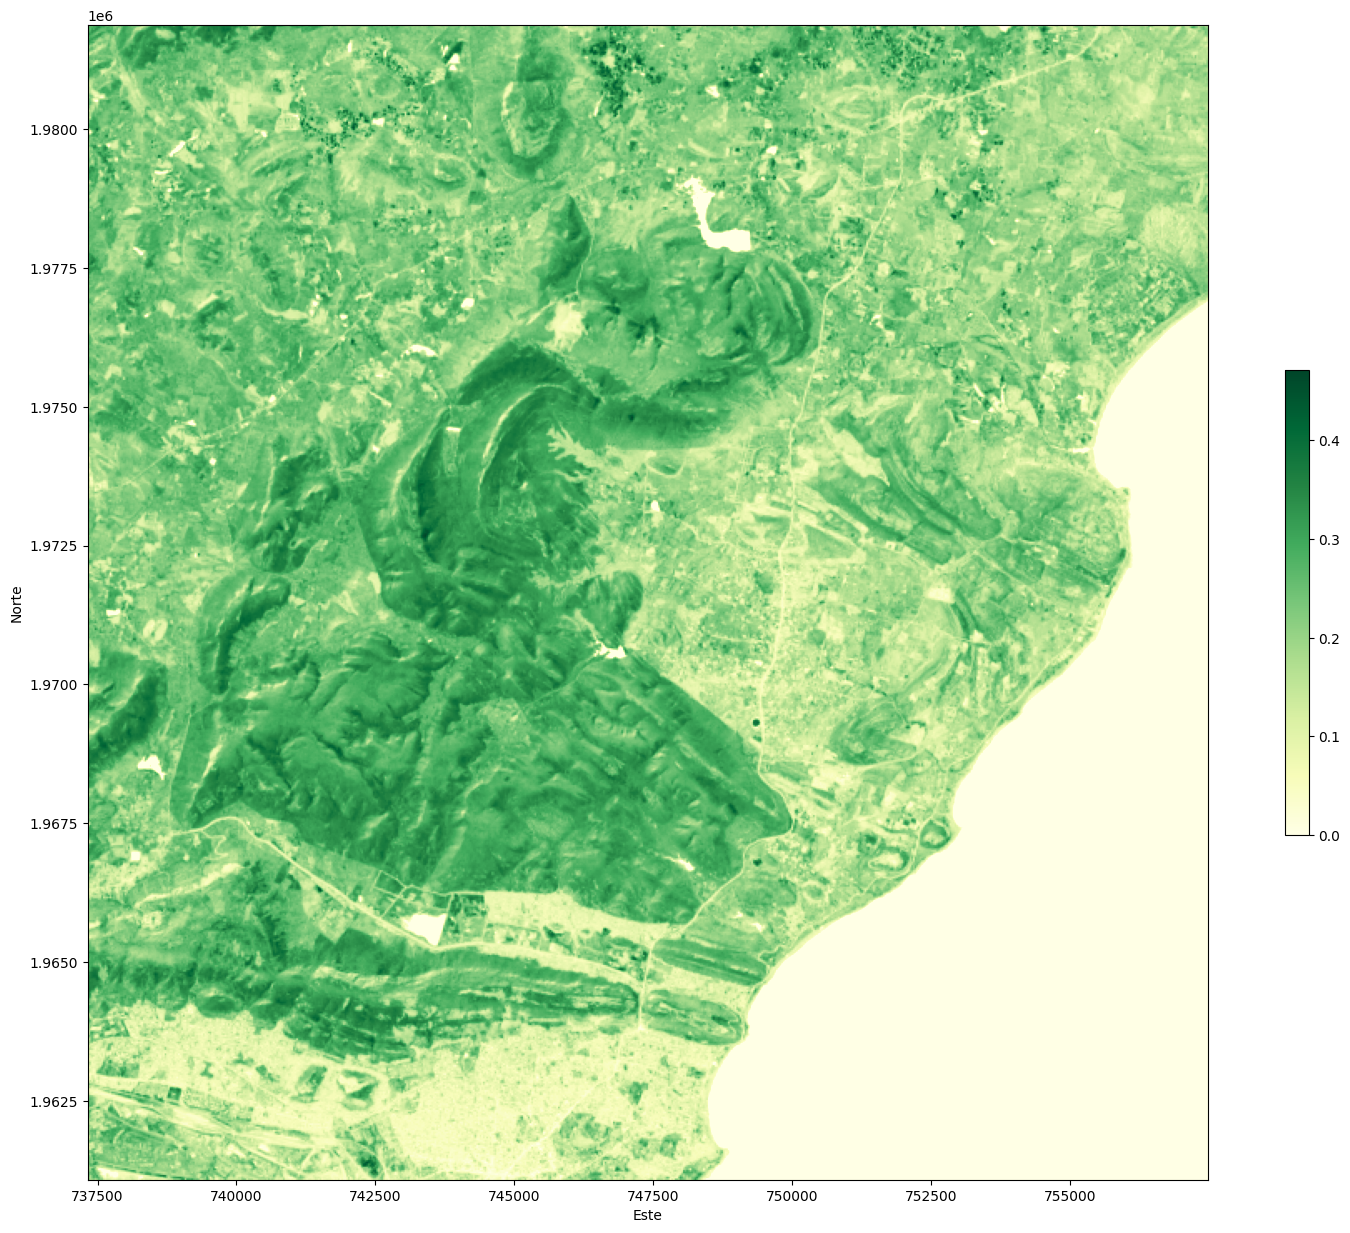

In [83]:
plotNDVI(path_NDVI_2015,extentArray,0,'YlGn')

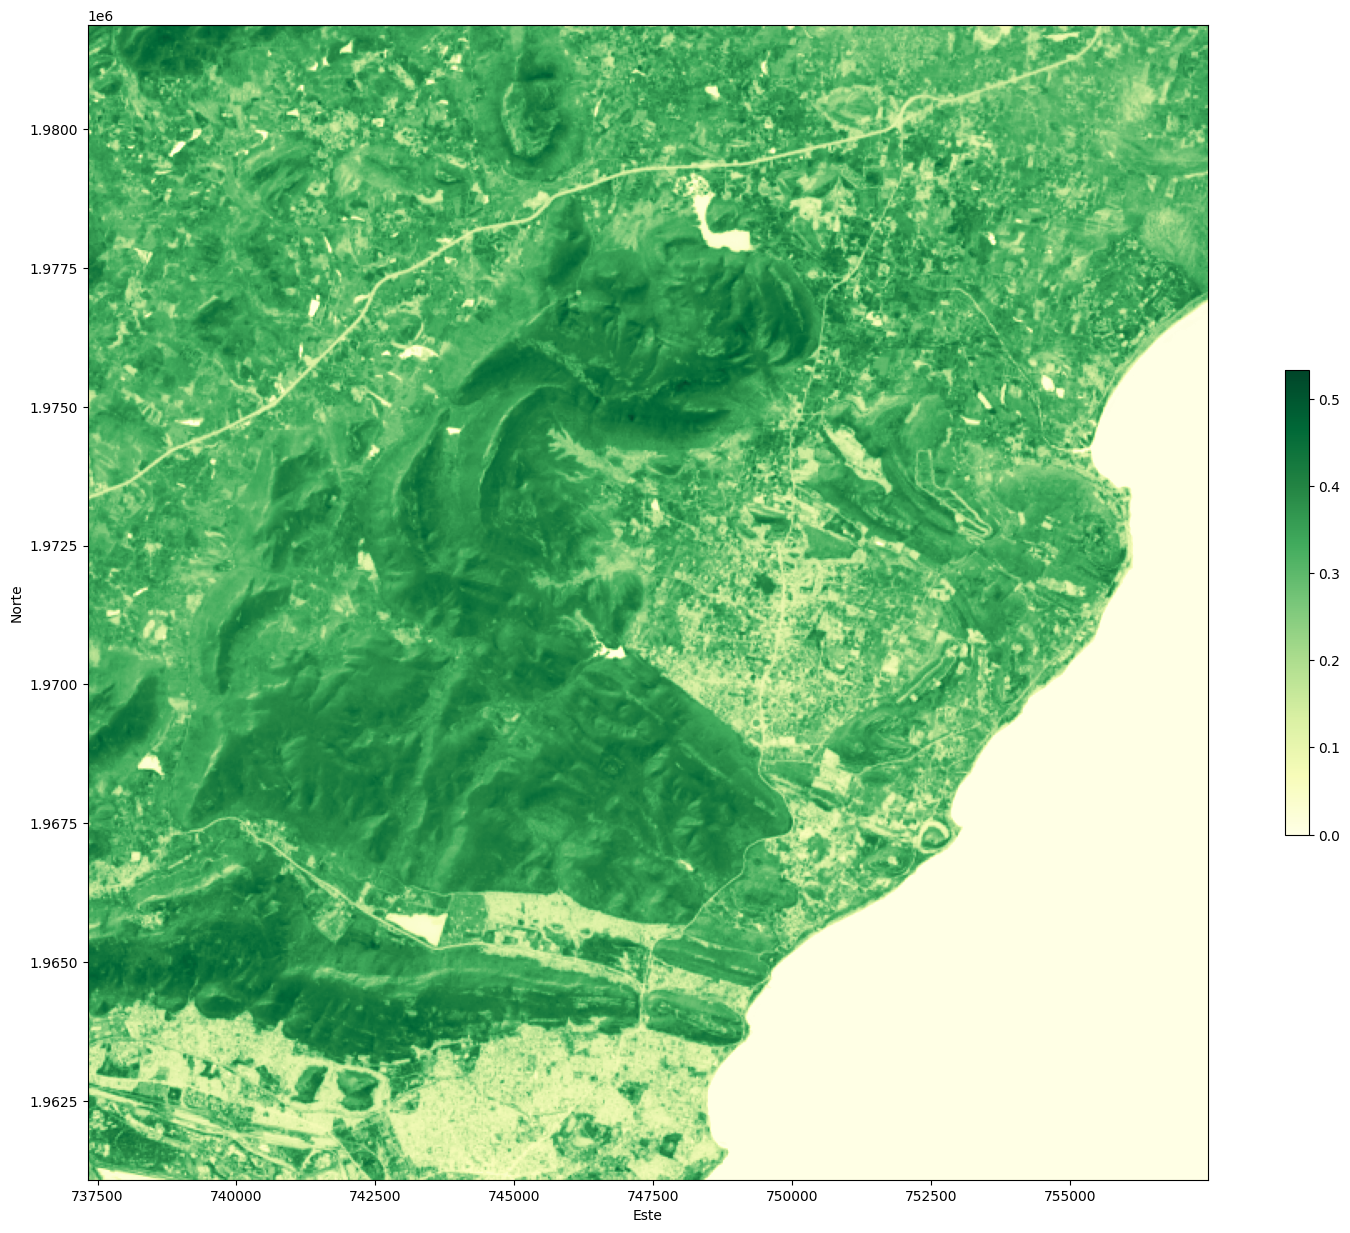

In [84]:
plotNDVI(path_NDVI_2021,extentArray,0,'YlGn')

## Create a land cover change image

We create a land cover change image based on the differences in NDVI from 2019 and 2014 imagery. The image will be stored as a separate file.

In [85]:
ndviChange = ndvi2021-ndvi2015
ndviChange = np.where((ndvi2015>-999) & (ndvi2021>-999),ndviChange,-999)
ndviChange
print(np.sum(ndviChange)/len(ndviChange))

39.82034632034632


In [86]:
saveRaster(ndviChange,path_NDVIChange_21_15,cols,rows,projection)

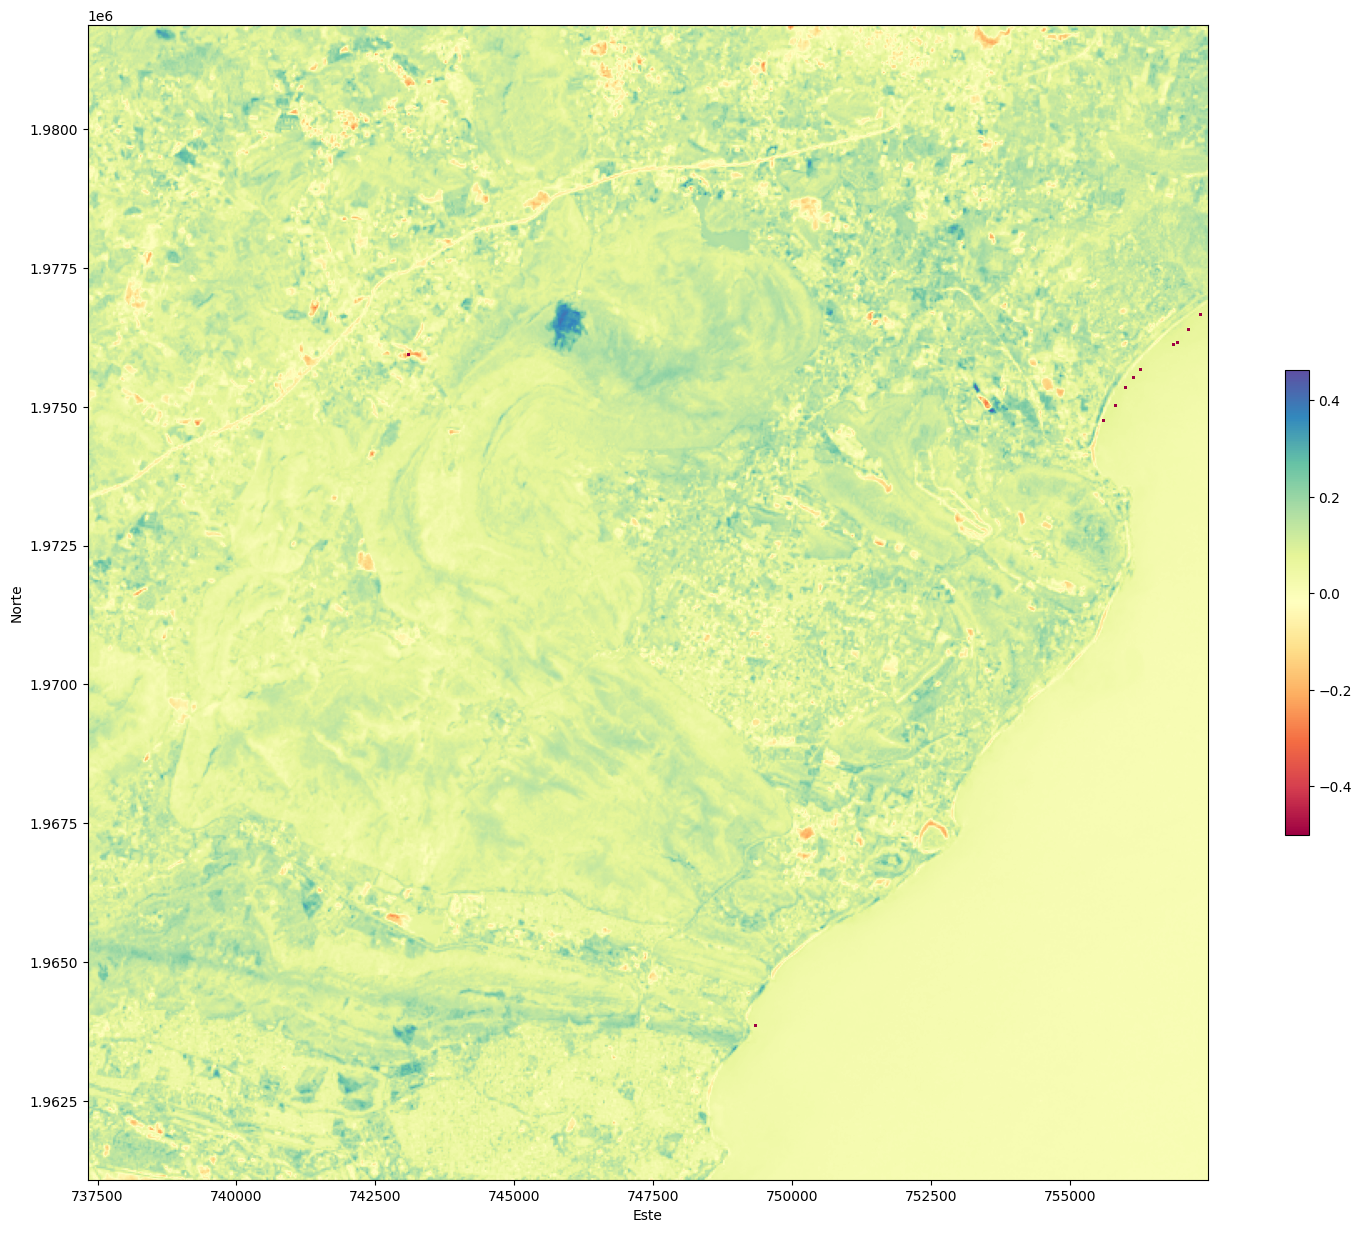

In [87]:
plotNDVI(path_NDVIChange_21_15,extentArray,-0.5,'Spectral')

## Create Contourlines
Finally, the countour lines from the NDVI values are generated. This is done with tool from the GDAL library.

In [88]:
Dataset_ndvi = gdal.Open(path_NDVIChange_21_15)#path_NDVI_2015
ndvi_raster = Dataset_ndvi.GetRasterBand(1)

ogr_ds = ogr.GetDriverByName("ESRI Shapefile").CreateDataSource(contours_NDVIChange_21_15)

prj=Dataset_ndvi.GetProjectionRef()#GetProjection()

srs = osr.SpatialReference(wkt=prj)#
#srs.ImportFromProj4(prj)

contour_shp = ogr_ds.CreateLayer('contour', srs)
field_defn = ogr.FieldDefn("ID", ogr.OFTInteger)
contour_shp.CreateField(field_defn)
field_defn = ogr.FieldDefn("ndviChange", ogr.OFTReal)
contour_shp.CreateField(field_defn)
#Generate Contourlines
gdal.ContourGenerate(ndvi_raster, 0.1, 0, [], 1, -999, contour_shp, 0, 1)
ogr_ds = None

In [89]:
'''
from google.colab import files


files.download('/content/NDVIChange_21_15.shp')

'''

"\nfrom google.colab import files\n\n\nfiles.download('/content/NDVIChange_21_15.shp')\n\n"

In [90]:
import os
os.path.getsize("/content/NDVIChange_21_15.shp")

3637248